<a href="https://colab.research.google.com/github/mohansivasai/Malaria-Cell-Images/blob/master/Malaria-cell-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the dependencies
import numpy as np
import pandas as pd
import csv
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Dense
print(tf.__version__)

2.2.0-rc2


In [0]:
#kaggle file configurations
!pip install kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohansivasai12","key":"6fb9013379729ec6afb9a93c01e54665"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 665M/675M [00:26<00:00, 30.3MB/s]
100% 675M/675M [00:26<00:00, 26.5MB/s]


In [0]:
ls

cell-images-for-detecting-malaria.zip  kaggle.json  sample_data/


In [0]:
#unzipping the file
import zipfile
local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [0]:
parasite_dir = os.path.join('/content/cell_images/cell_images/Parasitized')
uninfected_dir = os.path.join('/content/cell_images/cell_images/Uninfected')

In [0]:
print(os.listdir(parasite_dir))
uninfected_img = os.listdir(uninfected_dir)

['C132P93ThinF_IMG_20151004_151733_cell_141.png', 'C82P43ThinF_IMG_20150817_124418_cell_168.png', 'C182P143NThinF_IMG_20151201_172216_cell_198.png', 'C136P97ThinF_IMG_20151005_141803_cell_128.png', 'C48P9thinF_IMG_20150721_161243_cell_148.png', 'C33P1thinF_IMG_20150619_115740a_cell_163.png', 'C132P93ThinF_IMG_20151004_153030_cell_41.png', 'C80P41ThinF_IMG_20150817_111544_cell_129.png', 'C97P58ThinF_IMG_20150917_150838_cell_158.png', 'C136P97ThinF_IMG_20151005_144449_cell_21.png', 'C166P127ThinF_IMG_20151117_194932_cell_227.png', 'C137P98ThinF_IMG_20151005_161659_cell_1.png', 'C168P129ThinF_IMG_20151118_160845_cell_152.png', 'C129P90ThinF_IMG_20151004_133538_cell_76.png', 'C66P27N_ThinF_IMG_20150818_163419_cell_201.png', 'C167P128ReThinF_IMG_20151201_105102_cell_252.png', 'C189P150ThinF_IMG_20151203_141615_cell_89.png', 'C99P60ThinF_IMG_20150918_141001_cell_113.png', 'C99P60ThinF_IMG_20150918_141620_cell_2.png', 'C180P141NThinF_IMG_20151201_165601_cell_193.png', 'C48P9thinF_IMG_20150721

In [0]:
#spliting the data into training and validation 
try:
  os.mkdir('/content/train/')
  os.mkdir('/content/test/')
  os.mkdir('/content/train/Parasitized')
  os.mkdir('/content/train/Uninfected')
  os.mkdir('/content/test/Parasitized')
  os.mkdir('/content/test/Uninfected')
except OSError:
  pass

In [0]:
from shutil import copyfile
import random

In [0]:
def split_data(source,train,test,split_size = 0.65):
  files = list(os.listdir(source))
  #print(files)
  train_len = int(len(files)*split_size)
  test_len = int(len(files)*(1-split_size))
  shuffled_list = random.sample(files,len(files))
  train_set = shuffled_list[:train_len]
  #print(train_set[:10])
  test_set  = shuffled_list[-test_len:]
  #print(len(test_set))
  for filename in train_set:
    #print(filename)
    sor =  source+filename
    dest = train + filename
    copyfile(sor,dest)
  for filename in test_set:
    #print(filename)
    sor = source + filename 
    dest = test + filename
    copyfile(sor,dest)


parasite_source = '/content/cell_images/Parasitized/'
train_para_dir  = '/content/train/Parasitized/'
test_para_dir = '/content/test/Parasitized/'
uninfected_source = '/content/cell_images/Uninfected/'
train_uninfect_dir = '/content/train/Uninfected/'
test_uninfect_dir = '/content/test/Uninfected/'

split_data(parasite_source,train_para_dir,test_para_dir)
split_data(uninfected_source,train_uninfect_dir,test_uninfect_dir)

In [0]:
print(len(os.listdir('/content/train/Parasitized')))
print(len(os.listdir('/content/train/Uninfected')))
print(len(os.listdir('/content/test/Parasitized')))
print(len(os.listdir('/content/test/Uninfected')))

11024
11024
2755
2755


In [0]:
#using image data generator
train_dir = '/content/train'
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=30,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)
val_dir = '/content/test'
val_datagen = ImageDataGenerator(rescale = 1./255,horizontal_flip=True,vertical_flip=True,fill_mode = 'nearest')
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size = (224,224),
    batch_size  = 32,
    class_mode = 'binary'
)

Found 22046 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [0]:
#using Resnet-50 model
input_shape = (224,224,3)
resnet = ResNet50(input_shape = input_shape,
                         include_top = False,
                         weights = 'imagenet')

In [0]:
for layer in resnet.layers:
  layer.trainable  = False
resnet.summary()


In [0]:
x = layers.Dropout(0.5)(resnet.output)
x = layers.Flatten()(x)
#x = layers.Dense(1024,activation = 'relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256,activation = 'relu')(x)
pred = layers.Dense(1,activation = 'sigmoid')(x)

model = Model(inputs = resnet.input,outputs = pred)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
#compile the model
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['acc'])

In [0]:
#callbacks
class MyCall(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = {}):
    if (logs.get('acc') > 0.9) and (logs.get('val_acc')>0.85):
      print('\n Reached the desired accuracy so stopping the training')
      self.model.stop_training = True
callback = MyCall()
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch:10**-8 * 10**(epoch/20))

In [0]:
#training the model
hist = model.fit_generator(
    train_gen,
    epochs = 10,
    validation_data = val_gen,
    verbose = 1,
    callbacks = [callback]#,lr_schedule]
)

Epoch 1/10
560/560 [==============================] - 271s 485ms/step - loss: 0.2256 - acc: 0.9250 - val_loss: 1.4748 - val_acc: 0.4999
Epoch 2/10
560/560 [==============================] - 261s 467ms/step - loss: 0.1838 - acc: 0.9343 - val_loss: 1.0260 - val_acc: 0.4999
Epoch 3/10
560/560 [==============================] - 260s 464ms/step - loss: 0.1797 - acc: 0.9371 - val_loss: 0.9282 - val_acc: 0.4999
Epoch 4/10
560/560 [==============================] - 262s 468ms/step - loss: 0.1662 - acc: 0.9394 - val_loss: 0.8665 - val_acc: 0.4999
Epoch 5/10
560/560 [==============================] - 263s 469ms/step - loss: 0.1621 - acc: 0.9409 - val_loss: 0.8670 - val_acc: 0.4999
Epoch 6/10
279/560 [=============>................] - ETA: 1:44 - loss: 0.1558 - acc: 0.9432

KeyboardInterrupt: ignored

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, 'loss')

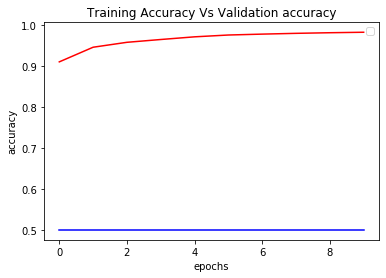

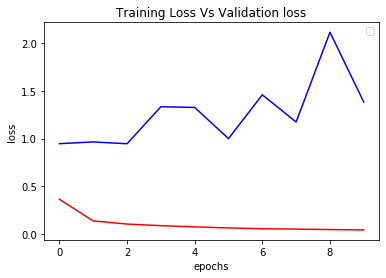

In [0]:
#plot the model
acc = hist.history['acc']
loss = hist.history['loss']
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs,acc,'r')
plt.plot(epochs,val_acc,'b')
plt.legend()
plt.title('Training Accuracy Vs Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.figure()
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.legend()
plt.title('Training Loss Vs Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')

In [0]:
#custom model from kaggle
def CNNbuild(inputShape , classes):
    model = tf.keras.models.Sequential()
    
    #inputShape = (height, width, channels)
    #chanDim = -1
    
    #if K.image_data_format() == 'channels_first':
        #inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))

    model.add(tf.keras.layers.Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'sigmoid'))
    
    return model


In [0]:
custom_model = CNNbuild(inputShape=(224,224,3),classes = 1)

In [0]:
custom_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 111, 111, 32)      128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 54, 54, 32)       

In [0]:
custom_model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics = ['acc'])

In [0]:
history = custom_model.fit_generator(
    train_gen,
    epochs = 10,
    validation_data = val_gen,
    verbose = 1,
    #callbacks = [callback]
)

Epoch 1/10
689/689 [==============================] - 262s 380ms/step - loss: 0.4788 - acc: 0.8013 - val_loss: 0.6009 - val_acc: 0.8015
Epoch 2/10
689/689 [==============================] - 256s 372ms/step - loss: 0.2631 - acc: 0.9074 - val_loss: 0.2278 - val_acc: 0.9309
Epoch 3/10
689/689 [==============================] - 258s 374ms/step - loss: 0.2459 - acc: 0.9147 - val_loss: 0.1964 - val_acc: 0.9316
Epoch 4/10
689/689 [==============================] - 256s 371ms/step - loss: 0.2288 - acc: 0.9242 - val_loss: 0.2270 - val_acc: 0.9221
Epoch 5/10
689/689 [==============================] - 254s 368ms/step - loss: 0.2304 - acc: 0.9216 - val_loss: 0.2140 - val_acc: 0.9307
Epoch 6/10
689/689 [==============================] - 254s 369ms/step - loss: 0.2181 - acc: 0.9265 - val_loss: 0.3378 - val_acc: 0.8528
Epoch 7/10
689/689 [==============================] - 255s 370ms/step - loss: 0.2080 - acc: 0.9300 - val_loss: 0.2025 - val_acc: 0.9289
Epoch 8/10
689/689 [============================

In [0]:
#plot the model
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs,acc,'r')
plt.plot(epochs,val_acc,'b')
plt.title('Training Accuracy Vs Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.figure()
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title('Training Loss Vs Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')